In [ ]:
import tarfile

with tarfile.open('/content/dtd-r1.0.1.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/content/dtd')

In [ ]:
!pip install tqdm

In [ ]:
!pip install -U scikit-image==0.19.3

In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, hog
from skimage.filters import gabor
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Load images and labels from DTD dataset directory
def load_images_labels(folder_path):
    images, labels = [], []
    categories = os.listdir(folder_path)
    for label, category in enumerate(categories):
        category_path = os.path.join(folder_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
              img = cv2.resize(img, (128, 128))
              images.append(img)
              labels.append(label)
            else:
              print(f"Error loading image: {img_path}")

    return np.array(images), np.array(labels), categories

In [ ]:
# Set dataset path and load images
dataset_path = '/content/dtd/dtd/images'
images, labels, categories = load_images_labels(dataset_path)

Error loading image: /content/dtd/dtd/images/waffled/.directory


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)



In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
                             brightness_range=[0.8, 1.2], zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
datagen.fit(X_train.reshape(-1, 128, 128, 1))



In [ ]:
# Feature Extraction Functions
def extract_lbp_features(image):
    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")
    return np.histogram(lbp.ravel(), bins=np.arange(0, 10), density=True)[0]

def extract_glcm_features(image):
    glcm = graycomatrix(image, distances=[1], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, homogeneity, energy, correlation]

def extract_gabor_features(image):
    gabor_feat = []
    for theta in (0, 1, 2, 3):  # Different orientations
        filt_real, _ = gabor(image, frequency=0.6, theta=theta * np.pi / 4)
        gabor_feat.append(filt_real.mean())
        gabor_feat.append(filt_real.var())
    return gabor_feat

def extract_hog_features(image):
    hog_feat, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_feat



In [ ]:
# Combine all features
def extract_combined_features(images):
    features = []
    for image in images:
        lbp_feat = extract_lbp_features(image)
        glcm_feat = extract_glcm_features(image)
        gabor_feat = extract_gabor_features(image)
        hog_feat = extract_hog_features(image)
        combined_features = np.concatenate([lbp_feat, glcm_feat, gabor_feat, hog_feat])
        features.append(combined_features)
    return np.array(features)



In [ ]:
# Extract features for train and test sets
X_train_features = extract_combined_features(X_train)
X_test_features = extract_combined_features(X_test)



In [ ]:
# Define a Small CNN for Feature Extraction
def build_cnn_feature_extractor(input_shape):
    model = models.Sequential([
        Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten()
    ])
    return model



In [ ]:
# Get CNN Features
X_train_cnn = X_train.reshape(-1, 128, 128, 1)
X_test_cnn = X_test.reshape(-1, 128, 128, 1)
cnn_model = build_cnn_feature_extractor((128, 128, 1))
X_train_cnn_features = cnn_model.predict(X_train_cnn)
X_test_cnn_features = cnn_model.predict(X_test_cnn)



141/141 ━━━━━━━━━━━━━━━━━━━━ 36s 255ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step


In [ ]:
# Combine CNN Features with Traditional Features
X_train_combined = np.concatenate([X_train_features, X_train_cnn_features], axis=1)
X_test_combined = np.concatenate([X_test_features, X_test_cnn_features], axis=1)



In [ ]:
from tqdm import tqdm
import time

def train_svm_with_progress(svm_model, X_train, y_train):
    print("Training the SVM classifier...")
    progress_bar = tqdm(total=100, desc="Training Progress", bar_format="{l_bar}{bar} [ time left: {remaining} ]")

    for _ in range(10):
        svm_model.fit(X_train, y_train)
        time.sleep(0.1)
        progress_bar.update(10)

    progress_bar.close()
    print("Training complete.")

svm_model = SVC(kernel='linear', random_state=42)

train_svm_with_progress(svm_model, X_train_combined, y_train)


Training the SVM classifier...


Training Progress: 100%|██████████ [ time left: 00:00 ]

Training complete.


In [ ]:
# Evaluate the model
y_pred = svm_model.predict(X_test_combined)
accuracy = np.mean(y_pred == y_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=categories))



Test Accuracy: 0.1800
F1 Score: 0.1792412317963663

Classification Report:
               precision    recall  f1-score   support

       bumpy       0.14      0.13      0.14        31
polka-dotted       0.18      0.16      0.17        25
      matted       0.13      0.14      0.14        29
    potholed       0.55      0.40      0.46        30
    freckled       0.41      0.38      0.39        24
crosshatched       0.37      0.32      0.34        22
 crystalline       0.18      0.14      0.16        29
     marbled       0.06      0.10      0.08        21
   zigzagged       0.27      0.38      0.32        24
      dotted       0.47      0.26      0.33        31
 honeycombed       0.06      0.05      0.05        20
   sprinkled       0.09      0.08      0.08        25
     cracked       0.50      0.13      0.21        31
       scaly       0.09      0.14      0.11        21
  perforated       0.20      0.21      0.21        28
       lined       0.31      0.48      0.38        21
     

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


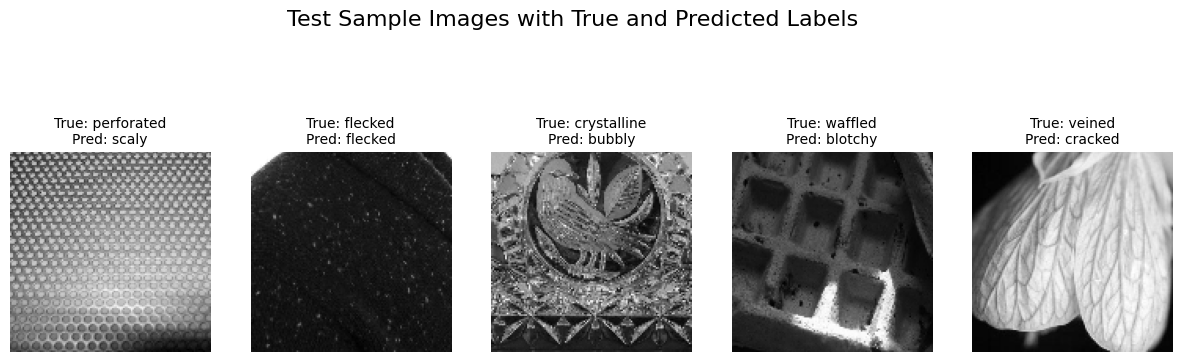

In [ ]:

import matplotlib.pyplot as plt

def display_test_samples_with_predictions(X_test, y_test, svm_model, cnn_model, categories, num_samples=5):

    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    X_test_sample = X_test[sample_indices]
    y_test_sample = y_test[sample_indices]

    X_test_sample_cnn = X_test_sample.reshape(-1, 128, 128, 1)
    cnn_features = cnn_model.predict(X_test_sample_cnn)

    traditional_features = extract_combined_features(X_test_sample)
    combined_features = np.concatenate([traditional_features, cnn_features], axis=1)

    y_pred_sample = svm_model.predict(combined_features)

    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, idx in enumerate(sample_indices):
        axs[i].imshow(X_test_sample[i], cmap='gray')
        axs[i].axis('off')
        true_label = categories[y_test_sample[i]]
        pred_label = categories[y_pred_sample[i]]
        axs[i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)

    plt.suptitle("Test Sample Images with True and Predicted Labels", fontsize=16)
    plt.show()

display_test_samples_with_predictions(X_test, y_test, svm_model, cnn_model, categories, num_samples=5)
